In [1]:
from iscat_lib import simulators
import matplotlib.pyplot as plt
from iscat_lib import analysis
import numpy as np
from scipy.optimize import minimize, curve_fit
from scipy.stats import rayleigh

In [2]:
plt.style.use('seaborn-poster')

# Simulate hopping diffusion

Brownian Diffusion Simulation: 100%|██████████| 10000/10000 [00:00<00:00, 135126.21it/s]

{'L': 1, 'Tmax': 10, 'd': 0.01, 'dL': 0.001, 'dt': 0.001, 'seed': 42}


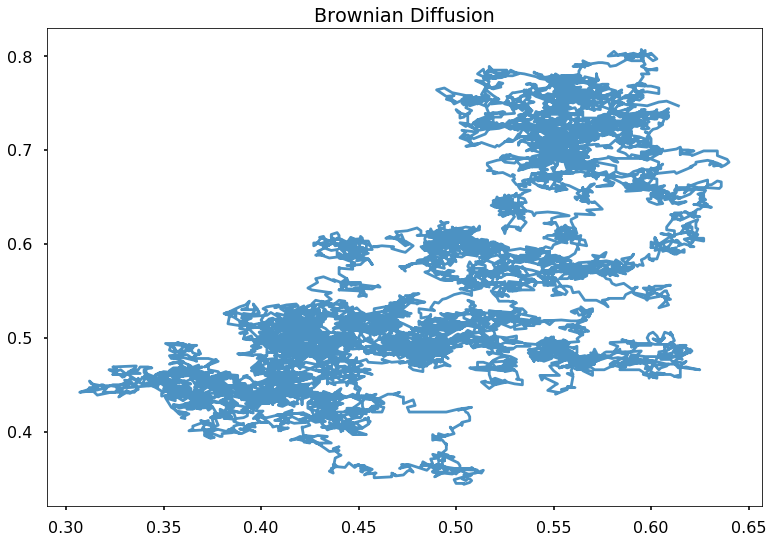

In [3]:
from iscat_lib import simulators
from importlib import reload
reload(simulators)

# Test Brownian diffusion
s = simulators.BrownianDiffusion(Tmax=10, seed=42)
s.print_parameters()
s.run()
s.display_trajectory()
plt.title("Brownian Diffusion")
plt.show()

Simulation:  22%|██▏       | 10757/50000 [00:00<00:00, 107563.43it/s]

Simulate hopping diffusion
Create hopping map


Simulation: 100%|██████████| 50000/50000 [00:00<00:00, 121589.68it/s]


{'Df': 8e-13,
 'HL': 1e-06,
 'HP': 0.01,
 'L': 1e-05,
 'Tmax': 2.5,
 'dL': 2e-08,
 'dt': 5e-05,
 'seed': 42}


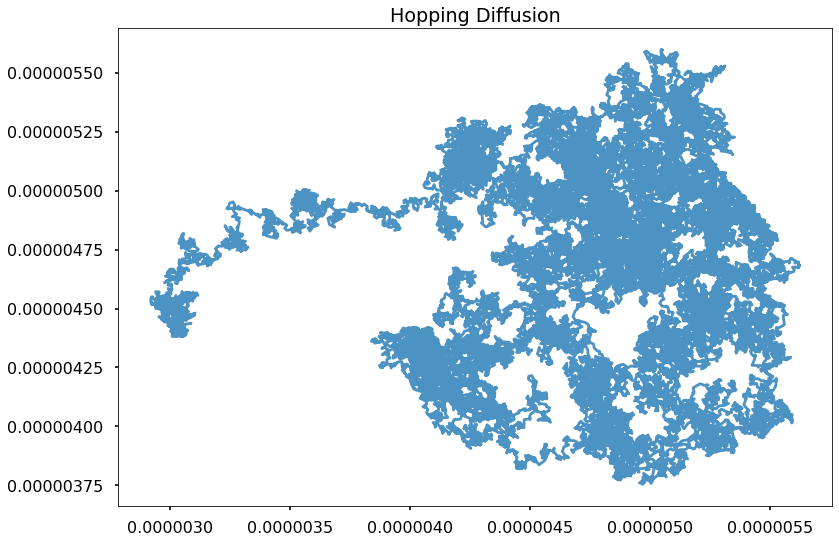

In [42]:
# Test hopping diffusion
s = simulators.HoppingDiffusion(Tmax=2.5, dt=0.5e-4, HL=1e-6, seed=42)
s.run()
s.display_trajectory()
s.print_parameters()
plt.title("Hopping Diffusion")
plt.show()

# Classical MSD Analysis

MSD calculation: 100%|██████████| 49997/49997 [00:13<00:00, 3683.19it/s] 


-50.671052046529034 -52.27849788409891


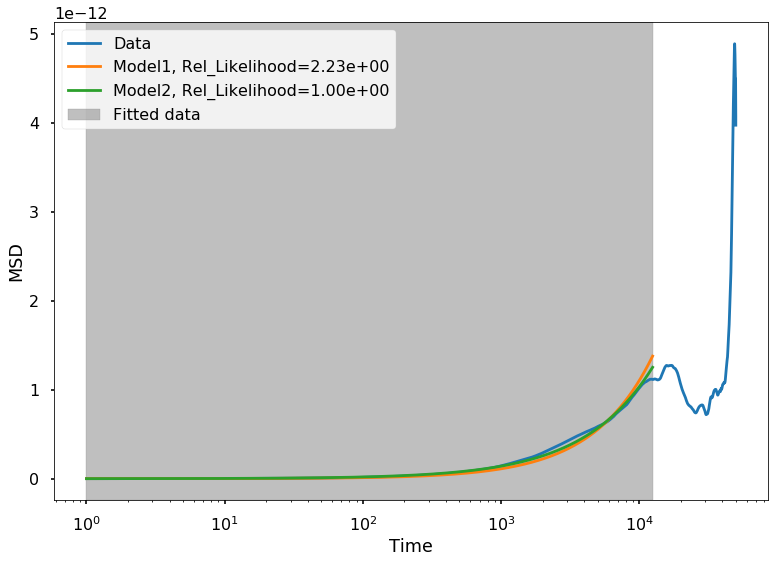

In [43]:
analysis.classicalMSDAnalysis([s.trajectory], useNormalization=False)

# Apparent Diffusion Coefficient Analysis

In [44]:
msd, msd_err = analysis.MSD(s.trajectory["x"], s.trajectory["y"])

MSD calculation: 100%|██████████| 49997/49997 [00:14<00:00, 3506.39it/s] 


In [45]:
dt = s.trajectory["t"][1]
R = 1/6
N = len(msd)
T = np.linspace(dt, dt*N, N, endpoint=True)
Dapp = msd / (4 * T * (1 - 2*R*dt / T))
Dapp /= Dapp.sum()
frac = 0.25
n_points = int(N * frac)

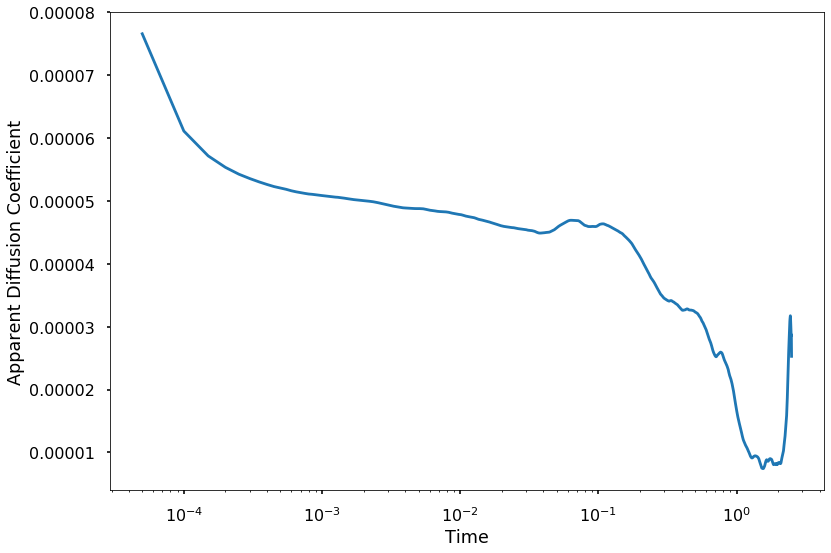

In [46]:
plt.semilogx(T, Dapp)
plt.ylabel("Apparent Diffusion Coefficient")
plt.xlabel("Time")
plt.show()

In [47]:
# Function to minimize 
def model_brownian(t, D, delta):
    y = D + delta ** 2 / (2 * t * (1 - 2 * R * dt / t))
    return y

def model_confined(t, D_micro, delta, tau):
    y = D_micro * (tau / t)*(1 - np.exp(- tau / t)) + delta ** 2 / (2 * t * (1 - 2 * R * dt / t))
    return y

def model_hop(t, D_macro, D_micro, delta, tau):
    y = D_macro + D_micro * (tau / t)*(1 - np.exp(- tau / t)) + delta ** 2 / (2 * t * (1 - 2 * R * dt / t))
    return y
    
    
def func_brownian(x):
    D, delta = x
    pred = model_brownian(T, D, delta)
    diff = (pred - Dapp)**2 
    return diff[0:n_points].sum()

def func_confined(x):
    D_micro, delta, tau = x
    pred = model_confined(T, D_micro, delta, tau)
    diff = (pred - Dapp)**2 
    return diff[0:n_points].sum()

def func_hop(x):
    D_macro, D_micro, delta, tau = x
    pred = model_hop(T, D_macro, D_micro, delta, tau)
    diff = (pred - Dapp)**2 
    return diff[0:n_points].sum()

In [48]:
# Perform bounded minimization. There is a convergence problem with some diffusion parameters
reg_brownian = minimize(func_brownian, [1,1], bounds=((0, np.inf), (0, np.inf)))
reg_confined = minimize(func_confined, [1,1,1], bounds=((0, np.inf), (0, np.inf), (0, np.inf)))
reg_hop = minimize(func_hop, [1,1,1,1], bounds=((0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf)))

print("Brownian model minimzation results: \n{}\n".format(reg_brownian))
print("Confined model minimization results: \n{}\n".format(reg_confined))
print("Hop model minimization results: \n{}\n".format(reg_hop))

Brownian model minimzation results: 
      fun: 4.521392370668071e-07
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.97972365e-03,  6.52619132e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 102
      nit: 33
   status: 0
  success: True
        x: array([3.71167581e-05, 7.71335903e-05])

Confined model minimization results: 
      fun: 1.7740052635779608e-05
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00000000e+00, 1.83343283e-05, 9.32458050e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 140
      nit: 34
   status: 0
  success: True
        x: array([0.00566406, 0.00013563, 0.        ])

Hop model minimization results: 
      fun: 4.520903622647275e-07
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.06585649e-03, 0.00000000e+00, 8.60911867e-05, 3.34199709e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 

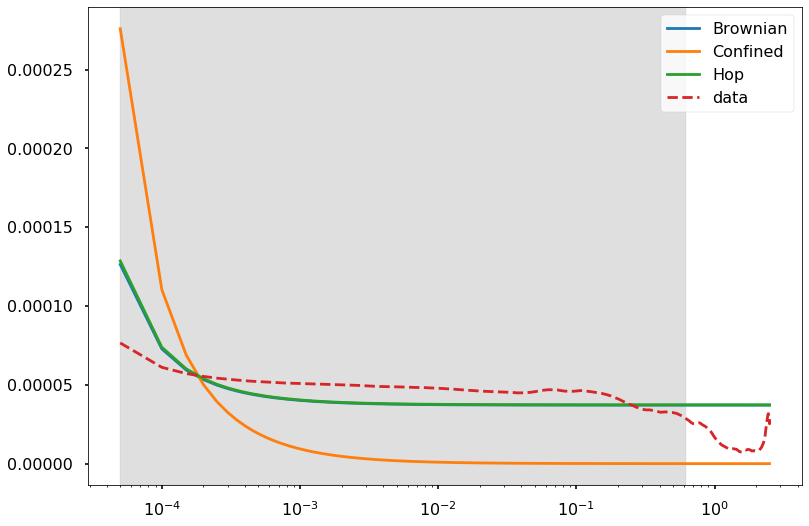

In [49]:
# Display the fitted models
plt.semilogx(T, model_brownian(T, *reg_brownian.x), label="Brownian")
plt.semilogx(T, model_confined(T, *reg_confined.x), label="Confined")
plt.semilogx(T, model_hop(T, *reg_hop.x), label="Hop")
plt.axvspan(T[0], T[n_points], color="gray", alpha=0.25)
plt.semilogx(T, Dapp, label='data', linestyle="--")
plt.legend()

## Different implementation (using curve_fit instead of minimize).

In [36]:
# This uses scipy.optimize.curve_fit instead of scipy.optimize.minimize, 
# it uses the msd_error as sigma for the non-linear least square
# it also normalize the x, y, and t variable to help with converge.
# Still it has convergence problems, due to the non-linear nature of the diffusion models.
# curve_fit raise an error if there is a convergence problem, but minimize will instead set the success to False
# This part will likely fail, which is the reason it is commented

# from iscat_lib import analysis
# from importlib import reload
# reload(analysis)
# analysis.adc_analysis([s.trajectory], useNormalization=False)

# Squared Displacement Analysis

\begin{equation}
P(\sqrt{SD_i}, T_i) = 2\pi A \frac{SD_i}{\sigma_i^2 T_i} \exp\left[-\frac{SD_i}{\sigma^2_i T_i}\right],
\end{equation}

where $SD_i$ is the squared displacement random variable evaluated for a time interval of $T_i$.

Rayleigh distribution is:
\begin{equation}
P(x; \sigma) = \frac{x}{\sigma^2} e^{- x^2 / (2\sigma^2)}
\end{equation}

The first equation doesn't have the Rayleigh form. For a temporary implementation example, I assumed that $x = \sqrt{SD_i/T_i}$ in the Rayleigh distribution.

In [50]:
# Squared-displacement
def squared_displacement(x, y, j):
    """Squared displacement at timepoint j"""
    N = len(x)
    idx_0 = np.arange(0, N-j-1, 1)
    idx_t = idx_0 + j
    
    pos_x = np.array(x)
    pos_y = np.array(y)
    SD = (pos_x[idx_t] - pos_x[idx_0])**2 + (pos_y[idx_t] - pos_y[idx_0])**2    
    
    # Sort the SD vlues from smallest to largest, this will be useful later
    SD.sort()
    
    return SD

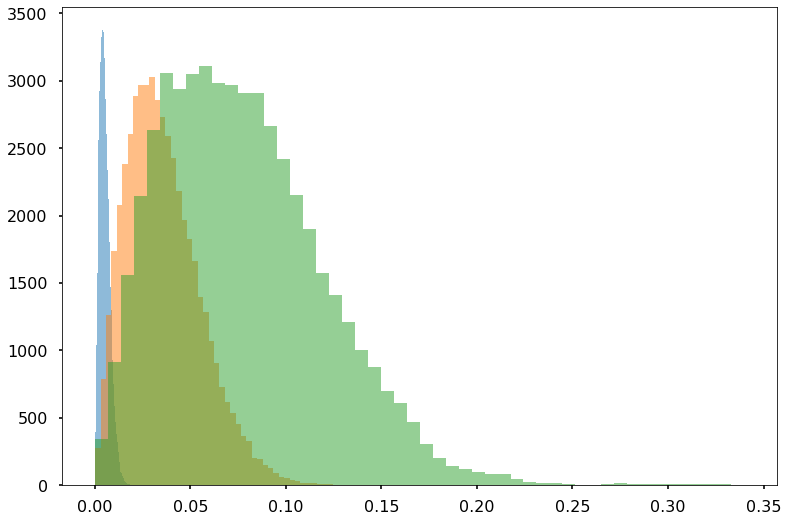

In [51]:
# Display some SD results
x = np.array(s.trajectory["x"])
y = np.array(s.trajectory["y"])
t = np.array(s.trajectory["t"])
dt = s.dt
x = (x - x.min()) / (x.max() - x.min())
y = (y - y.min()) / (y.max() - y.min())
plt.hist(np.sqrt(squared_displacement(x,y,1)), 50, alpha=0.5); 
plt.hist(np.sqrt(squared_displacement(x,y,50)), 50, alpha=0.5);
plt.hist(np.sqrt(squared_displacement(x,y,250)), 50, alpha=0.5);

plt.show()

## Estimate D_app from SD

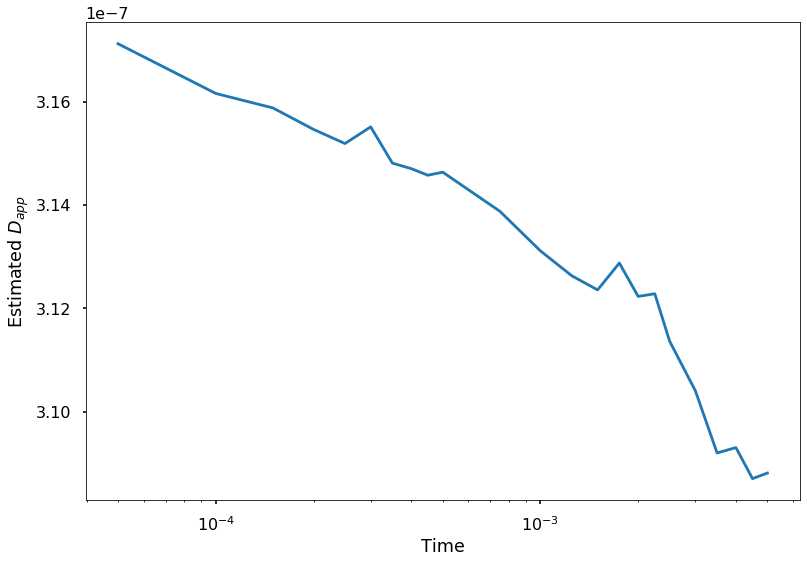

In [53]:
# We define a list of timepoints at which to calculate the distribution
J = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90,100] # can be more, I don't think less.
display_fit = False
dt = s.dt
# Perform the analysis for a sigle track
dapp_list = []
for j in J:
    # Calculate the SD
    x = np.array(s.trajectory["x"])
    y = np.array(s.trajectory["y"])
    sd = squared_displacement(x, y, j)
    
    x_fit = np.sqrt(sd / (j * dt))
   
    reg = rayleigh.fit(x_fit)    

    if display_fit:
        eval_x = np.linspace(x_fit.min(), x_fit.max(), 100)
        plt.plot(eval_x, rayleigh.pdf(eval_x, *reg), label="Fit")
        plt.hist(x_fit, 32, density=True, alpha=0.5, label="Data")
        plt.legend()
        plt.show()
    
    sigma = reg[1]
    dapp = sigma / 4 # This is the equivalent of Dapp
    dapp_list.append(dapp)
    
plt.semilogx(np.array(J) * dt, dapp_list); 
plt.xlabel("Time")
plt.ylabel("Estimated $D_{app}$")
plt.show()

## Fit the diffusion models

In [54]:
T = np.array(J) * s.dt
X = np.array(dapp_list)
R = 1/6

def model_brownian(t, D, delta):
    y = D + delta ** 2 / (2 * t * (1 - 2 * R * dt / t))
    return y

def model_confined(t, D_micro, delta, tau):
    y = D_micro * (tau / t)*(1 - np.exp(- tau / t)) + delta ** 2 / (2 * t * (1 - 2 * R * dt / t))
    return y

def model_hop(t, D_macro, D_micro, delta, tau):
    y = D_macro + D_micro * (tau / t)*(1 - np.exp(- tau / t)) + delta ** 2 / (2 * t * (1 - 2 * R * dt / t))
    return y

def func_brownian_sd(x):
    D, delta = x
    pred = model_brownian(T, D, delta)
    diff = (pred - X)**2 
    return diff.sum()

def func_confined_sd(x):
    D_micro, delta, tau = x
    pred = model_confined(T, D_micro, delta, tau)
    diff = (pred - X)**2 
    return diff.sum()

def func_hop_sd(x):
    D_macro, D_micro, delta, tau = x
    pred = model_hop(T, D_macro, D_micro, delta, tau)
    diff = (pred - X)**2 
    return diff.sum()

In [55]:
# Perform bounded minimization. There is a convergence problem with some diffusion parameters
reg_brownian = minimize(func_brownian_sd, [1,1], bounds=((0, np.inf), (0, np.inf)))
reg_confined = minimize(func_confined_sd, [1,1,1], bounds=((0, np.inf), (0, np.inf), (0, np.inf)))
reg_hop = minimize(func_hop_sd, [1,1,1,1], bounds=((0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf)))

print("Brownian model minimzation results: \n{}\n".format(reg_brownian))
print("Confined model minimization results: \n{}\n".format(reg_confined))
print("Hop model minimization results: \n{}\n".format(reg_hop))

Brownian model minimzation results: 
      fun: 8.756495500910894e-10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.25975440e-04, 8.55339398e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 102
      nit: 33
   status: 0
  success: True
        x: array([0.00000000e+00, 4.18946001e-05])

Confined model minimization results: 
      fun: 3.635997293132442e-10
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00000000e+00, 4.44503790e-05, 6.61006989e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 148
      nit: 36
   status: 0
  success: True
        x: array([4.27943247e-04, 3.38307843e-05, 0.00000000e+00])

Hop model minimization results: 
      fun: 7.196877223610087e-10
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.13172340e-04, 0.00000000e+00, 7.39023097e-05, 1.02612734e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  

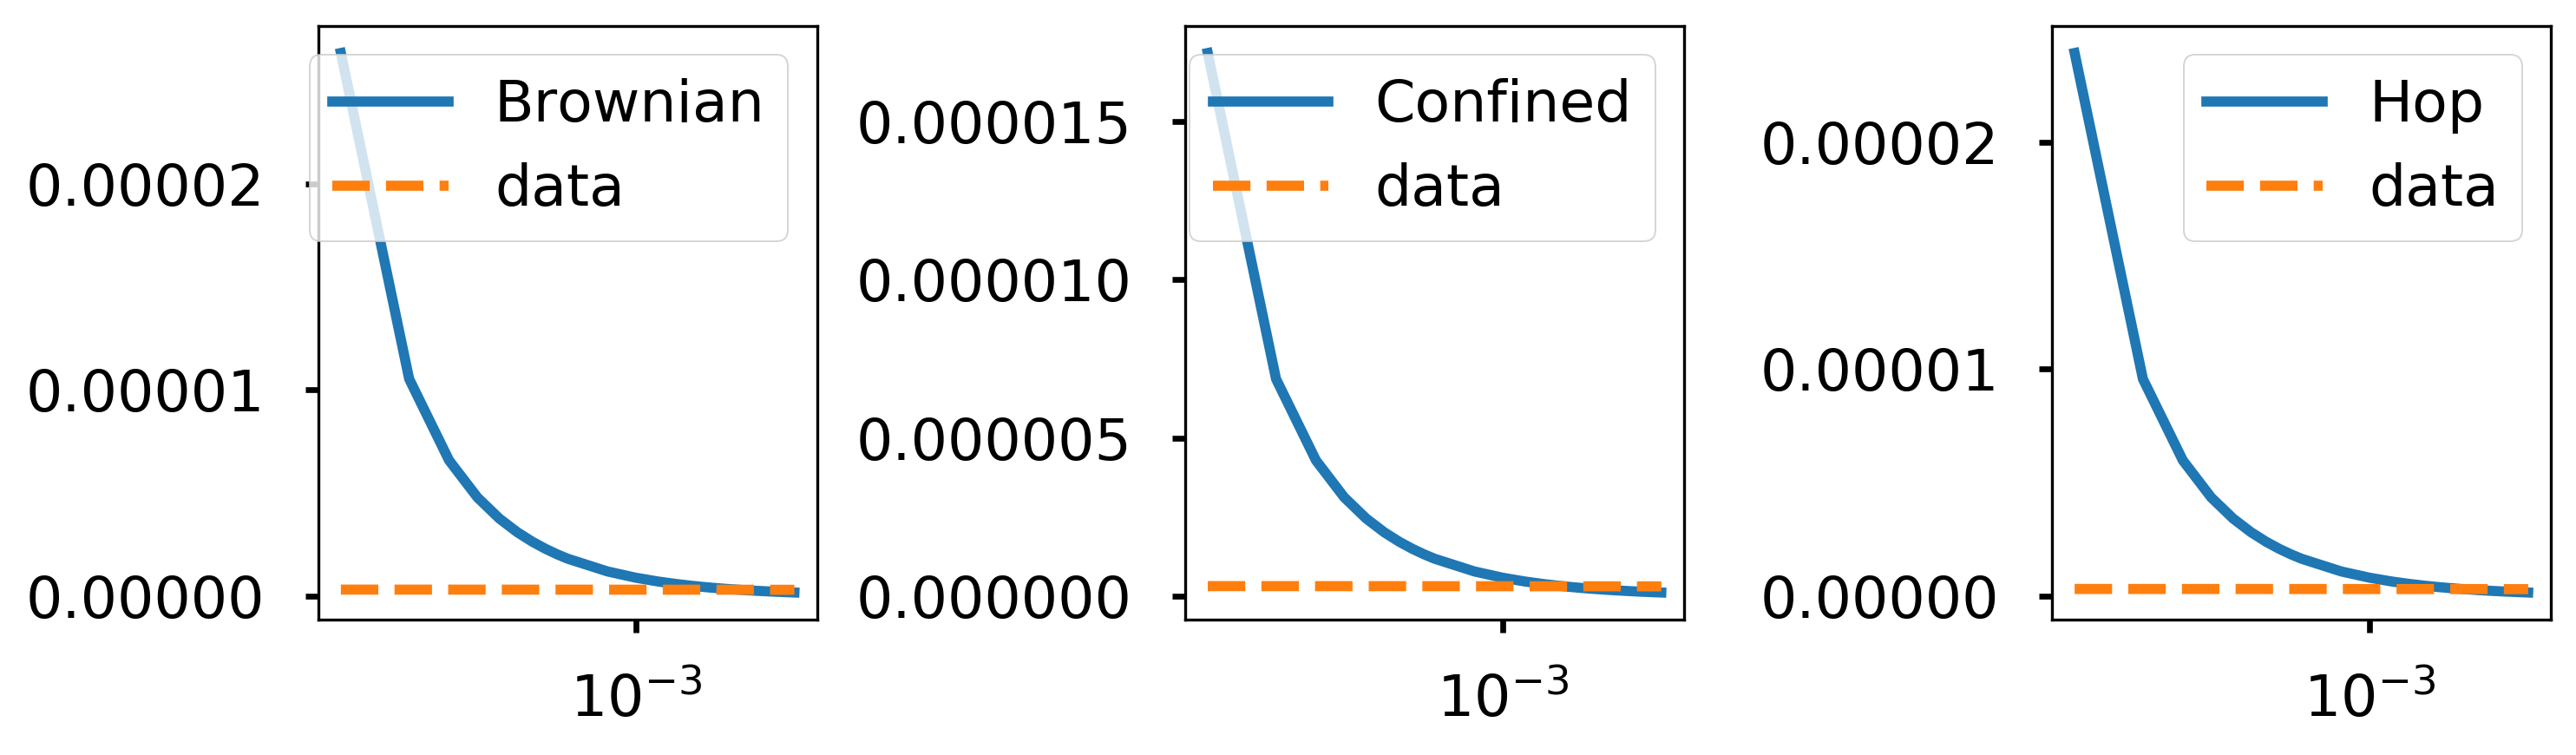

In [56]:
# Display the fitted models
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3), dpi=300)

ax1.semilogx(T, model_brownian(T, *reg_brownian.x), label="Brownian")
ax1.semilogx(T, X, label='data', linestyle="--")
ax1.legend()

ax2.semilogx(T, model_confined(T, *reg_confined.x), label="Confined")
ax2.semilogx(T, X, label='data', linestyle="--")
ax2.legend()

ax3.semilogx(T, model_hop(T, *reg_hop.x), label="Hop")
ax3.semilogx(T, X, label='data', linestyle="--")
ax3.legend()

plt.tight_layout()
plt.show()